# **Intro**
In this notebook I set up conditional semi-supervised VAE that attempts to predict the proportions of MNIST numbers that have been superimposed on top of one another.

This is similar to the DIVA, where we use the rotation as labels and instead of having partially labeled numbers, we will have partially labeled number proportions. 
In that setup some labels are ommited to make it semi-supervised, which we will also do.
This will mimic the idea that we have bulk case vs. control examples (we don't know the proportions) and  simulate bulk samples from single-cell profiles, (where we don't have treatment data).
Using both of these sources of data we hope that we can work in OOD stuff.
Also, we use the M1+M2 formulation of semi-supervised as described here: "Semi-supervised Learning with Deep Generative Models", https://arxiv.org/abs/1406.5298

The difference in this model are the following: 


1.   We are learning proportions of numbers in an image, not a specific number.
This means that this is regression, not classification.
2.   We put the constraint directly on mu, not on an external classifier.
This is because we want to be able to augment mu and reconstruct in a logical manner.
For example, we want to be able to simulate the mixture of specific cell types by augmenting mu.
3.   We add in an additional classification loss for classification of treated vs. untreated.
We hope that by learning two separate processes (stack proportions and case/control classification) we will have enough information to compose them and handle out-of-distribution responses.
This did not work when we simply used the treatment as a condition, instead we will need to have a downstream classifier, linked to z, that will predict treatment status.



A lot of the model code was taken from this tutorial: https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb

And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/




# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [137]:
import os, sys

NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')

In [138]:
# prelude: set up git, etc.
%cd {NB_ROOT_PATH}
!( source setup.sh )

/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood
Ensuring ssh keys exist...
Copied key(s) to /root/.ssh/
total 16
-rw-r--r-- 1 root root   43 Aug 10 23:19 config
-rw------- 1 root root  432 Aug 10 23:19 id_rsa
-rw-r--r-- 1 root root  113 Aug 10 23:19 id_rsa.pub
-rw-r--r-- 1 root root 3094 Aug 10 22:15 known_hosts


In [139]:
%%bash
# do your git operations here
git push
git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   experiments/DIVA_stacked_mnist.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


Everything up-to-date


# **Imports**

In [140]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from sklearn.manifold import TSNE

# programming stuff
import time
import os
import pickle
from pathlib import Path

# Load the TensorBoard notebook extension
%load_ext tensorboard

# load methods from other files
from mnist_preprocessing import generate_data as gd

# I disable eager execution ... forgot why
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

warnings.filterwarnings('ignore')
%pylab inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Populating the interactive namespace from numpy and matplotlib


# **Load / Pre-process data**
Import + reshape the non-rotated MNIST data

In [141]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(X_train.shape)
print(X_test.shape)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

print(Y_train)

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 ... 5 6 8]


Import + reshape and rotate MNIST data.
In our single-cell analogy, rotation is a treatment and the number value is a cell-type.

In [142]:
(X_train_r, Y_train_r), (X_test_r, Y_test_r) = mnist.load_data()

# now add in the rotation
def rotate_90(img):
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

# rotate the training data
X_train_r = np.array([rotate_90(xi) for xi in X_train_r])
Y_train_r = Y_train

# rotate the test data
X_test_r = np.array([rotate_90(xi) for xi in X_test_r])
Y_test_r = Y_test

# reshape the data
X_train_r = X_train_r.astype('float32') / 255.
X_test_r = X_test_r.astype('float32') / 255.

n_pixels = np.prod(X_train_r.shape[1:])
X_train_r = X_train_r.reshape((len(X_train_r), n_pixels))
X_test_r = X_test_r.reshape((len(X_test_r), n_pixels))

print(X_train_r.shape)
print(X_test_r.shape)
print(Y_train_r)

(60000, 784)
(10000, 784)
[5 0 4 ... 5 6 8]


Demo the data, to make sure everything works

Proportion of each MNIST number to be superimposed: [56  8  0  0 24  0  9  1  1  1]
10 stacked 5's


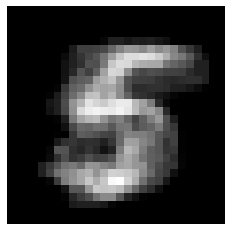

Rotated 10 stacked 5's


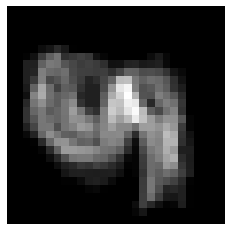

100 stacked 5's


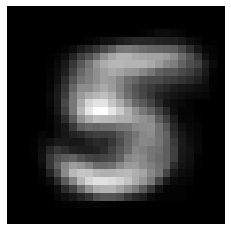

50 random 0's and 50 random 1's


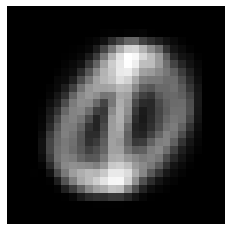

Rotated 50 random 0's and 50 random 1's


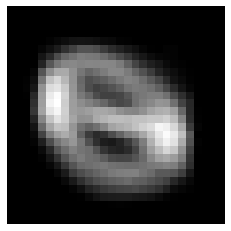

Random Stack


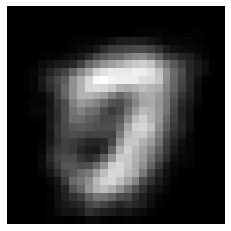

Proportion of each MNIST number: [12  1  0  4  1 24  1 53  0  4]
Rotated Random Stack


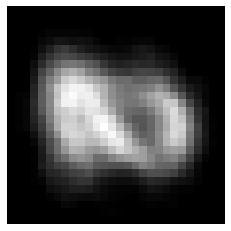

Proportion of each rotated MNIST number: [ 0  0 40  0  1  0 30  0 27  2]


In [143]:
# show how each method works and give some sample output
prop_vec = gd.gen_prop_vec_lognormal()
print(f"Proportion of each MNIST number to be superimposed: {prop_vec}")

# print 10 random 5's
print("10 stacked 5's")
single_num = gd.gen_single_num_sum(10, 5, X_train, Y_train)
plt.imshow(single_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

# print 10 random 5's
print("Rotated 10 stacked 5's")
single_num = gd.gen_single_num_sum(10, 5, X_train_r, Y_train_r)
plt.imshow(single_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

# print 100 random 5's
print("100 stacked 5's")
single_num = gd.gen_single_num_sum(100, 5, X_train, Y_train)
plt.imshow(single_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

# print 50 random 0's and 50 random 1's
print("50 random 0's and 50 random 1's")
zero_five_num = gd.gen_prop_num_sum([50, 50, 0, 0, 0, 0, 0, 0, 0, 0], X_train, Y_train)
plt.imshow(zero_five_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

print("Rotated 50 random 0's and 50 random 1's")
zero_five_num = gd.gen_prop_num_sum([50, 50, 0, 0, 0, 0, 0, 0, 0, 0], X_train_r, Y_train_r)
plt.imshow(zero_five_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

print("Random Stack")
y_stacked, x_stacked = gd.make_stacked_sample(X_train, Y_train)
plt.imshow(x_stacked.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print(f"Proportion of each MNIST number: {y_stacked}")


print("Rotated Random Stack")
y_stacked, x_stacked = gd.make_stacked_sample(X_train_r, Y_train_r)
plt.imshow(x_stacked.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print(f"Proportion of each rotated MNIST number: {y_stacked}")


Now generate all the new images

In [144]:
# in a loop randomly generate images and save the X and Y
num_samples_train = 200000
num_samples_test = 20000

# make / load training data
training_data_path = "./data/stacked_train_lognorm.pkl"
X_stack_train, Y_stack_train =  gd.make_all_stacked_samples(X_train, Y_train, 
                                                         training_data_path, 
                                                         num_samples_train)

# make / load test data
testing_data_path = "./data/stacked_test_lognorm.pkl"
X_stack_test, Y_stack_test =  gd.make_all_stacked_samples(X_test, Y_test, 
                                                         testing_data_path, 
                                                         num_samples_test)


##################################################
#####. Rotated MNIST
##################################################

# make / load training data
training_r_data_path = "./data/stacked_rotated_train_lognorm.pkl"
X_stack_train_r, Y_stack_train_r =  gd.make_all_stacked_samples(X_train_r, 
                                                         Y_train_r, 
                                                         training_r_data_path, 
                                                         num_samples_train)


# make / load test data
testing_r_data_path = "./data/stacked_rotated_test_lognorm.pkl"
X_stack_test_r, Y_stack_test_r =  gd.make_all_stacked_samples(X_test_r, 
                                                         Y_test_r, 
                                                         testing_r_data_path, 
                                                         num_samples_test)


##################################################
#####. Put it all together
##################################################


X_full_train = np.concatenate([X_stack_train, X_stack_train_r])
Y_full_train = np.concatenate([Y_stack_train, Y_stack_train_r])

X_full_test = np.concatenate([X_stack_test, X_stack_test_r])
Y_full_test = np.concatenate([Y_stack_test, Y_stack_test_r])

print(X_full_test.shape)
print(X_full_train.shape)

### also create the condition label (regular=0, rotated=1) 

Label_train = np.concatenate([np.zeros(Y_stack_train.shape[0]), np.ones(Y_stack_train_r.shape[0])])
Label_test = np.concatenate([np.zeros(Y_stack_test.shape[0]), np.ones(Y_stack_test_r.shape[0])])
label_train = to_categorical(Label_train)
label_test = to_categorical(Label_test)


(40000, 784)
(400000, 784)


# **Model Definition**


## Hyperparameters

In [145]:
batch_size = 250
n_epoch = 5

# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = 10 # latent space size, one latent dimension PER MNIST digit
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of encoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer

# classifir hidden layer
n_cls_h = 5

activ = 'relu'
optim = Adam(learning_rate=0.001)

n_x = X_full_train.shape[1]
n_y = Y_full_train.shape[1]
n_label = label_train.shape[1]

print(f"length of X {n_x} and length of y {n_y} and n_label {n_label}")



length of X 784 and length of y 10 and n_label 2


## Encoder

In [146]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))

# concatenate input with the label 
inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_h = Dense(encoder_dim, activation=activ, name="encoder_1")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space
mu_slack = Dense(n_z, activation='linear', name = "mu_slack")(encoder_h)
l_sigma_slack = Dense(n_z, activation='linear', name = "sigma_slack")(encoder_h)

mu_prop = Dense(n_z, activation='linear', name = "mu_prop")(encoder_h)
l_sigma_prop = Dense(n_z, activation='linear', name = "sigma_prop")(encoder_h)

mu_rot = Dense(n_label, activation='linear', name = "mu_rot")(encoder_h)
l_sigma_rot = Dense(n_label, activation='linear', name = "sigma_rot")(encoder_h)

## Latent Space

In [147]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_z])
z_prop = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_prop")([mu_prop, l_sigma_prop, n_z])
z_rot = Lambda(sample_z, output_shape = (n_label, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label])

z_concat = concat([z_slack, z_prop, z_rot])

## Decoder + Classifiers

In [148]:
def null_f(args):
    return args

# set up decoder network
# this is a decoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

# this is the proportions we try to estimate
decoder_props = ReLU(name = "mu_prop_pred") 

# this is the rotation we try to estimate
rot_props = ReLU(name = "mu_rot_pred")

# we use this to get sigma to do sampling later
decoder_sigma = Lambda(null_f, name = "l_sigma_prop_pred")

# link them together
h_p = decoder_hidden(z_concat)
outputs = decoder_out(h_p)

rotation_outputs = rot_props(mu_rot)

prop_outputs = decoder_props(mu_prop)
sigma_outputs = decoder_sigma(l_sigma_prop)


d_in = Input(shape=(n_z+n_z+n_label,))
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)




## Loss

In [149]:
beta_kl = 10
beta_kl_rot = 10
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl_prop = beta_kl * K.sum(K.exp(l_sigma_prop) + K.square(mu_prop) - 1. - l_sigma_prop, axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_slack = beta_kl_rot * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_prop + kl_rot + kl_slack

def KL_loss(y_true, y_pred):
	return(beta_kl * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

prop_loss_scale = 100
def prop_loss(y_true, y_pred):
	return K.sum((y_true -  y_pred)**2, axis=-1) * prop_loss_scale

def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    return recon



## Make the computational graph

In [150]:
cls_prop_vae = Model(X, [outputs, prop_outputs, rotation_outputs, sigma_outputs])

cls_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss, None])


encoder = Model(X, [z_slack, mu_prop, z_rot])

decoder = Model(d_in, d_out)

print(cls_prop_vae.summary())


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder_1 (Dense)               (None, 512)          401920      input_25[0][0]                   
__________________________________________________________________________________________________
sigma_slack (Dense)             (None, 10)           5130        encoder_1[0][0]                  
__________________________________________________________________________________________________
sigma_prop (Dense)              (None, 10)           5130        encoder_1[0][0]                  
___________________________________________________________________________________________

# **Experiments**

Now lets train and evaluate the model.
First we train with only some proportions of rotated 3's..
We will then decrease the proportion of rotated 3's in samples from 0.5 to 0.

In [151]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))


Setup the data so that we remove all the examples with a high proportion of rotated 3's

In [152]:
# ok now we will attempt OOD
# remove rotated 3s

unrot_idx = range(0, 200000)
rot_idx = range(200000, 400000)

X_train_unrot = X_full_train[unrot_idx,:]
Y_train_unrot = Y_full_train[unrot_idx,:]
label_train_unrot = label_train[unrot_idx,:]

X_train_rot = X_full_train[rot_idx,:]
Y_train_rot = Y_full_train[rot_idx,:]
label_train_rot = label_train[rot_idx,:]


# now remove all samples where 3 makes up more than 50%
# and is rotated
keep_rot_idx = Y_train_rot[:,3] < 0.8
X_train_rot_no3 = X_train_rot[keep_rot_idx,:]
Y_train_rot_no3 = Y_train_rot[keep_rot_idx,:]
label_train_rot_no3 = label_train_rot[keep_rot_idx,:]

# now put it all together
X_train_no3rot = np.concatenate((X_train_unrot, X_train_rot_no3))
Y_train_no3rot = np.concatenate((Y_train_unrot, Y_train_rot_no3))
label_train_no3rot = np.concatenate((label_train_unrot, label_train_rot_no3))


Now train

In [153]:
# now take a subsample of the full dataset
sample_size = 50000
rand_idx = np.random.choice(X_train_no3rot.shape[0], size=sample_size, replace=False)

cls_prop_vae_hist = cls_prop_vae.fit(X_train_no3rot[rand_idx,:], 
                                    [X_train_no3rot[rand_idx,:], 
                                     Y_train_no3rot[rand_idx,:], 
                                     label_train_no3rot[rand_idx,:]], 
                      verbose = 1, batch_size=batch_size, epochs=n_epoch,
                      validation_data = (X_full_test, [X_full_test, Y_full_test, label_test]),
                      callbacks = [EarlyStopping(patience = 5)])


z_slack, mu_prop, z_rot = encoder.predict(X_full_test, batch_size=batch_size)
test_error = [mean_abs_error(mu_prop[idx], Y_full_test[idx]) 
                  for idx in range(0, X_full_test.shape[1])]

print(f"mean test_error: {np.round(np.mean(test_error), decimals=3)}\n"
      f"median test_error: {np.round(np.median(test_error), decimals=3)}\n"
      f"max test_error: {np.round(np.max(test_error), decimals=3)}")




Train on 50000 samples, validate on 40000 samples
Epoch 1/5
50000/50000 [==============================] - 11s 223us/sample - loss: 257.9728 - decoder_out_loss: 250.2514 - mu_prop_pred_loss: 6.4113 - mu_rot_pred_loss: 1.3100 - val_loss: 226.9293 - val_decoder_out_loss: 224.5405 - val_mu_prop_pred_loss: 1.3431 - val_mu_rot_pred_loss: 1.0457
Epoch 2/5
50000/50000 [==============================] - 10s 206us/sample - loss: 225.6883 - decoder_out_loss: 223.4132 - mu_prop_pred_loss: 1.2615 - mu_rot_pred_loss: 1.0136 - val_loss: 225.8064 - val_decoder_out_loss: 223.7219 - val_mu_prop_pred_loss: 1.1436 - val_mu_rot_pred_loss: 0.9409
Epoch 3/5
50000/50000 [==============================] - 10s 207us/sample - loss: 225.0634 - decoder_out_loss: 222.9401 - mu_prop_pred_loss: 1.1516 - mu_rot_pred_loss: 0.9718 - val_loss: 225.5120 - val_decoder_out_loss: 223.4547 - val_mu_prop_pred_loss: 1.1207 - val_mu_rot_pred_loss: 0.9365
Epoch 4/5
50000/50000 [==============================] - 10s 209us/sample 

In [154]:
z_rot

array([[ 1.1545804 ,  0.75260776],
       [-0.45467898, -0.13541773],
       [ 0.88257456,  0.7098197 ],
       ...,
       [-0.19359557,  0.6663417 ],
       [-0.29291284,  0.3371011 ],
       [ 0.6746737 ,  2.0167193 ]], dtype=float32)

# **Inspect the output**

We will take two examples from our training and see how well it reconstructs.
We first look at the ground truth so we know what we should expect.

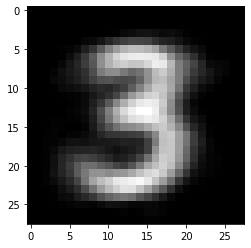

[0.   0.   0.   0.89 0.   0.07 0.   0.04 0.   0.  ]
[1. 0.]


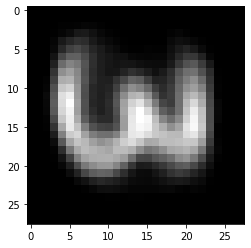

[0.02 0.03 0.04 0.9  0.   0.   0.   0.   0.   0.01]
[0. 1.]


In [155]:
plot_idx = 0 #20
plt.imshow(X_full_train[plot_idx].reshape(28, 28), cmap = plt.cm.gray)
plt.show()
print(Y_full_train[plot_idx])
print(label_train[plot_idx])

plt.imshow(X_full_train[200000+plot_idx].reshape(28, 28), cmap = plt.cm.gray)
plt.show()
print(Y_full_train[200000+plot_idx])
print(label_train[200000+plot_idx])


Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

In [156]:
plot_idx = 0

z_slack, mu_prop, z_rot = encoder.predict(X_full_train, batch_size=250)
encoded_X0 = mu_prop[plot_idx]
rotated_vec = z_rot[plot_idx]
print(f"1-hot encoded condition vector: {Y_full_train[plot_idx]}")
encoded_X0[encoded_X0<0] = 0
print(f"output from encoder (ReLU applied): {encoded_X0}")

print(f"rotation: {label_train[plot_idx]}")
rotated_vec[rotated_vec<0] = 0
print(f"output from encoder (ReLU applied): {rotated_vec}")


encoded_X0 = mu_prop[200000+plot_idx]
rotated_vec = z_rot[200000+plot_idx]

print(f"1-hot encoded condition vector: {Y_full_train[200000+plot_idx]}")
print(f"output from encoder (no ReLU applied): {encoded_X0}")
encoded_X0[encoded_X0<0] = 0
print(f"output from encoder (ReLU applied): {encoded_X0}")

print(f"rotation: {label_train[200000+plot_idx]}")
rotated_vec[rotated_vec<0] = 0
print(f"output from encoder (ReLU applied): {rotated_vec}")

1-hot encoded condition vector: [0.   0.   0.   0.89 0.   0.07 0.   0.04 0.   0.  ]
output from encoder (ReLU applied): [0.         0.         0.         0.7878508  0.         0.03211261
 0.         0.02874773 0.         0.        ]
rotation: [1. 0.]
output from encoder (ReLU applied): [0.19363785 0.3209419 ]
1-hot encoded condition vector: [0.02 0.03 0.04 0.9  0.   0.   0.   0.   0.   0.01]
output from encoder (no ReLU applied): [-0.00426721 -0.00568972  0.0220369   0.83280414  0.03604297 -0.01465547
 -0.04628383 -0.07355676 -0.00487724 -0.01450678]
output from encoder (ReLU applied): [0.         0.         0.0220369  0.83280414 0.03604297 0.
 0.         0.         0.         0.        ]
rotation: [0. 1.]
output from encoder (ReLU applied): [0.        1.7695861]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...
[t-SNE] Computed neighbors for 5000 samples in 0.610s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.083526
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.020752
[t-SNE] KL divergence after 300 iterations: 1.802271
t-SNE done! Time elapsed: 13.30519962310791 seconds
(5000, 2)
(5000, 2)


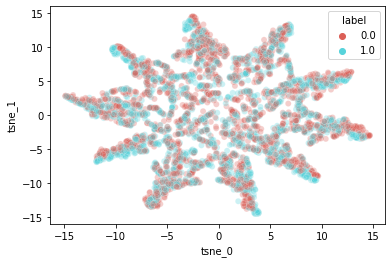

In [157]:
# plot proportions
z_slack, mu_prop, z_rot = encoder.predict(X_full_test, batch_size=250)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_full_test.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['label'] = Label_test[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)




[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...
[t-SNE] Computed neighbors for 5000 samples in 0.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.108853
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.292953
[t-SNE] KL divergence after 300 iterations: 1.357843
t-SNE done! Time elapsed: 12.864661931991577 seconds
(5000, 2)
(5000, 2)


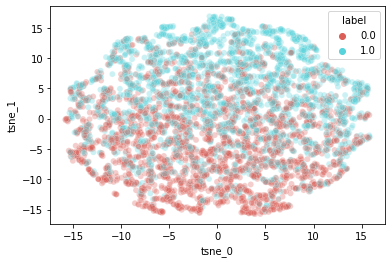

In [158]:
# plot rotation
z_test = z_rot
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_full_test.shape[0], n_label)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['label'] = Label_test[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.975s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.930922
[t-SNE] KL divergence after 50 iterations with early exaggeration: 85.147301
[t-SNE] KL divergence after 300 iterations: 3.159858
t-SNE done! Time elapsed: 15.272437810897827 seconds
(5000, 2)
(5000, 2)


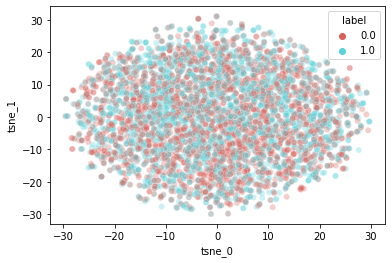

In [159]:
# plot remaining variance
z_test = z_slack
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_full_test.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['label'] = Label_test[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)



In [160]:
print(X_full_test[0].shape) 
print(Y_full_test[0].shape)

def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

output_prop_test = cls_prop_vae.predict(X_full_test, batch_size=250)[1]

test_error = [mean_abs_error(output_prop_test[idx], Y_full_test[idx]) 
                  for idx in range(0, X_full_test.shape[0])]

print(f"mean test_error: {np.round(np.mean(test_error), decimals=3)}\n"
      f"median test_error: {np.round(np.median(test_error), decimals=3)}\n"
      f"max test_error: {np.round(np.max(test_error), decimals=3)}")


output_prop = cls_prop_vae.predict(X_full_train, batch_size=250)[1]
train_error = [mean_abs_error(output_prop[idx], Y_full_train[idx]) 
                  for idx in range(0, X_full_train.shape[0])]

print(f"mean train_error: {np.round(np.mean(train_error), decimals=3)}\n"
      f"median train_error: {np.round(np.median(train_error), decimals=3)}\n"
      f"max train_error: {np.round(np.max(train_error), decimals=3)}")


(784,)
(10,)
mean test_error: 0.019
median test_error: 0.018
max test_error: 0.063
mean train_error: 0.019
median train_error: 0.019
max train_error: 0.064


rotated 1


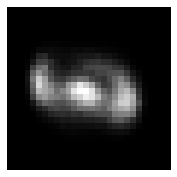

In [170]:

def method_sample_z(args):
    mu, l_sigma = args
    eps = np.random.normal(size=(batch_size, n_z), loc=0., scale=1.)
    return mu + np.exp(l_sigma / 2) * eps

def sample_digit(digit, Y_test, digit_scale, rotate):
  digit_idx = np.where(Y_test == digit)

  label_vec = np.array([1., 0.]).reshape((1, 2))
  if rotate:
    label_vec = np.array([0., 1.]).reshape((1, 2))

  pred_input = X_full_test[digit_idx[0][0:250]]
  test_X, test_mu, test_label, test_lsigma = cls_prop_vae.predict(pred_input, batch_size=250)

  encoded_X0 = np.ones(10)*0.01
  encoded_X0[digit] = digit_scale
  rand_lsigma = np.random.random_integers(low = 0, high = 249)
  z_0_digit = method_sample_z([encoded_X0, test_lsigma])
  z_0_digit = z_0_digit[rand_lsigma].reshape((1,10))
  return(z_0_digit)

digit_img = 1
z_0_digit = sample_digit(digit_img, Y_test, 10, rotate=True)
plt.figure(figsize=(3, 3))

# it is rotated
rotate_1hot = np.array([0., 10.])

# slack, prop, rot
slack_sample = [0,0,0,0,0,0,0,0,0,0]
pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

print(f"rotated {digit_img}")
plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

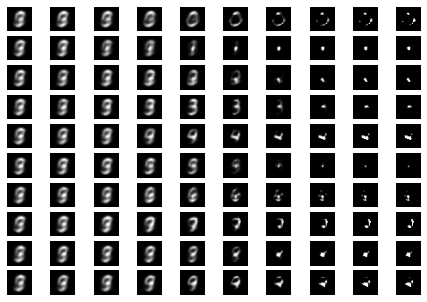

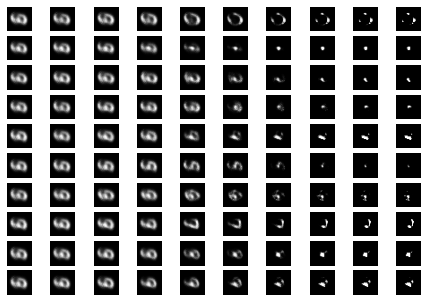

In [173]:
img_it = 0
sides = 10
slack_sample = [0,0,0,0,0,0,0,0,0,0]
rotate_scale = 10


rotate_1hot = np.array([rotate_scale, 0.])
rotate_val = False
for i in range(0, sides):
    for j in range(0, sides):
        z_0_digit = sample_digit(i, Y_test, 2**j, rotate=rotate_val)
        pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

        decoded = decoder.predict(pred_input)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()


rotate_1hot = np.array([0., rotate_scale])
rotate_val = True
img_it = 0
sides = 10
for i in range(0, sides):
    for j in range(0, sides):
        z_0_digit = sample_digit(i, Y_test, 2**j, rotate=rotate_val)
        pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

        decoded = decoder.predict(pred_input)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

In [163]:
# predict rotated numbers

# normalizing the data to make the neural network easier to learn
x_train_r = normalize(X_train_r, axis=1)
x_test_r = normalize(X_test_r, axis=1)

#choosing the sequential model
classification_model = Sequential()

#defining the architecture of the model
X_class = Input(shape=(n_x,))
classification_model.add(X_class)
classification_model.add(Dense(128, activation='relu'))
classification_model.add(Dense(128, activation='relu'))
classification_model.add(Dense(10, activation='softmax'))

#defining the parameters to train the model
classification_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#training the model
classification_model.fit(x_train_r,Y_train_r,epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 7s 114us/sample - loss: 0.3259 - accuracy: 0.9062
Epoch 2/3
60000/60000 [==============================] - 8s 131us/sample - loss: 0.1340 - accuracy: 0.9598
Epoch 3/3
60000/60000 [==============================] - 7s 119us/sample - loss: 0.0922 - accuracy: 0.9712


In [164]:

num_correct = 0
num_digits = 10
num_rep = 100
rotate_1hot = np.array([0., 10])
rotate_val = True
slack_sample = method_sample_z([0,1])[0]
acc = []
for digit_idx in range(0, num_digits):
  num_correct = 0
  for idx_rep in range(0, num_rep):
    z_0_digit = sample_digit(digit_idx, Y_test, 2**4, rotate=rotate_val)
    pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

    decoded = decoder.predict(pred_input)
    predictions = classification_model.predict(decoded)
    #print(f"true: {idx} pred: {np.argmax(predictions)}")
    if(digit_idx == np.argmax(predictions)):
      num_correct += 1
  acc = np.append(acc, num_correct)

print(np.mean(acc))
print(acc)

55.4
[100.  89.  92.   0.  66.   0.   0. 100.   7. 100.]


In [165]:
sample_digit(3, Y_test, 2**5, rotate=rotate_val)

array([[ 1.64525459, -1.16285057,  2.24742986, 33.07174245, -0.63078399,
         0.93123407, -0.56831497, -1.32332922,  0.45432502,  0.48185536]])